In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    StratifiedKFold,
    train_test_split,
)

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn import set_config


set_config(display="diagram")
sns.set_style(style="darkgrid")
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [2]:
df = pd.read_csv(r"D:\Python\data analysis projects\heart\heart.csv")
df.head()
df.shape

(1025, 14)

In [3]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

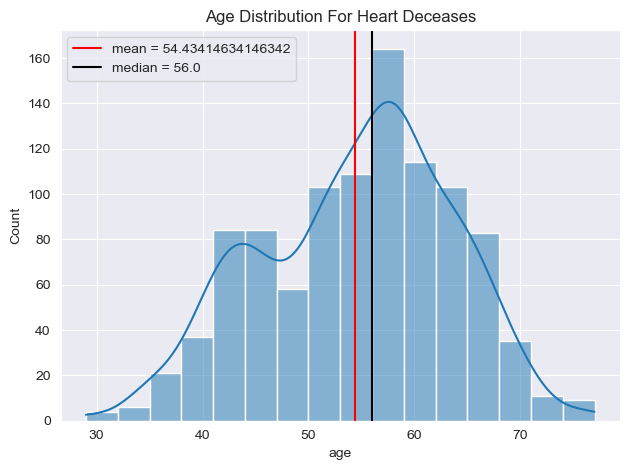

In [4]:
age_mean: float = np.mean(a=df["age"])
age_median: float = np.median(a=df["age"])

sns.histplot(data=df["age"], kde=True, bins=16)
plt.axvline(x=age_mean, color="red", label=f"mean = {age_mean}")
plt.axvline(x=age_median, color="black", label=f"median = {age_median}")
plt.title(label="age distribution for heart deceases".title())
plt.tight_layout()
plt.legend()
plt.show()

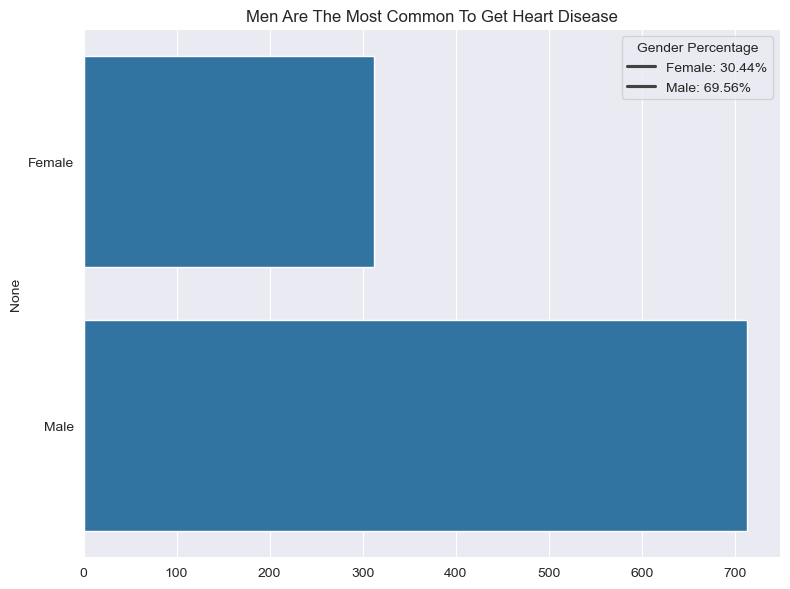

In [5]:
# Group by 'sex' and count occurrences
gender = df.groupby(by="sex").size()
gender.index = ["Female", "Male"]

# Calculate percentages for the legend
percentage = []
for i in range(len(gender)):
    perc = round((gender.values[i] / gender.values.sum()) * 100, 2)
    percentage.append(f"{gender.index[i]}: {perc}%")

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=gender.values, y=gender.index, orient="h")

# Add legend with percentages
plt.legend(percentage, title="Gender Percentage", loc="upper right")

# Title and layout
plt.title("Men Are the Most Common to Get Heart Disease".title())
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
round(df.describe(), 4)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000,1025.0000
mean,54.4341,0.6956,0.9424,131.6117,246.0000,0.1493,0.5298,149.1141,0.3366,1.0715,1.3854,0.7541,2.3239,0.5132
std,9.0723,0.4604,1.0296,17.5167,51.5925,0.3565,0.5279,23.0057,0.4728,1.1751,0.6178,1.0308,0.6207,0.5001
min,29.0000,0.0000,0.0000,94.0000,126.0000,0.0000,0.0000,71.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,48.0000,0.0000,0.0000,120.0000,211.0000,0.0000,0.0000,132.0000,0.0000,0.0000,1.0000,0.0000,2.0000,0.0000
50%,56.0000,1.0000,1.0000,130.0000,240.0000,0.0000,1.0000,152.0000,0.0000,0.8000,1.0000,0.0000,2.0000,1.0000
75%,61.0000,1.0000,2.0000,140.0000,275.0000,0.0000,1.0000,166.0000,1.0000,1.8000,2.0000,1.0000,3.0000,1.0000
max,77.0000,1.0000,3.0000,200.0000,564.0000,1.0000,2.0000,202.0000,1.0000,6.2000,2.0000,4.0000,3.0000,1.0000


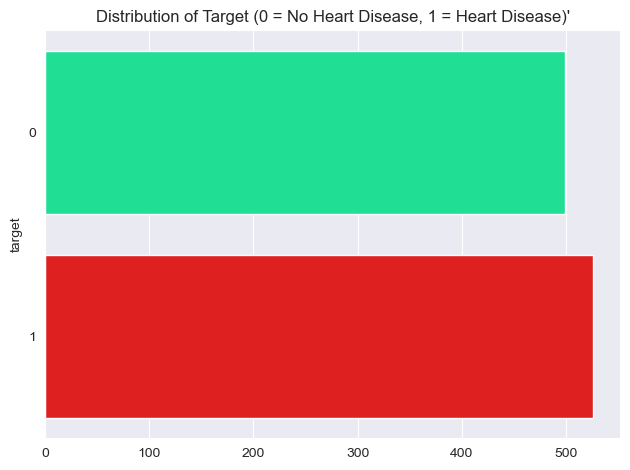

In [7]:
heart_disease = df["target"].value_counts()
color_palette = ["#00FF9C", "red"]
sns.barplot(
    x=heart_disease.values, y=heart_disease.index, orient="h", palette=color_palette
)
plt.title("Distribution of Target (0 = No Heart Disease, 1 = Heart Disease)'")
plt.tight_layout()

In [8]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [9]:
# normalize the data
normalize = StandardScaler()

target_columns = ["age", "trestbps", "chol", "thalach"]

df[target_columns] = normalize.fit_transform(df[target_columns])

In [10]:
from pandas import DataFrame


X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y , shuffle=True, stratify=y, train_size=0.2, random_state=101)
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model_grid = {
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False],
        },
    },
    "AdaBoostClassifier": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1, 1.0],
            "algorithm": ['SAMME', 'SAMME.R'],
        },
    },
    "BaggingClassifier": {
        "model": BaggingClassifier(),
        "params": {
            "n_estimators": [10, 50, 100],
            "max_samples": [0.5, 1.0],
            "max_features": [0.5, 1.0],
            "bootstrap": [True, False],
        },
    },
    "GradientBoostingClassifier": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
            "subsample": [0.8, 1.0],
        },
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "XGBClassifier": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),  # Adjusted for compatibility
        "params": {
            "n_estimators": [100],  # Reduced to a single option
            "learning_rate": [0.1],  # Reduced to a single option
            "max_depth": [3, 5],     # Kept two options for variety
            "subsample": [0.8],      # Reduced to a single option
            "colsample_bytree": [0.8],  # Reduced to a single option
        },
    },
    "LGBMClassifier": {
        "model": LGBMClassifier(),
        "params": {
            "use_boost_from_score": [True],
            "class_weight": ['balanced'],  # Adjusts for class imbalance
            "n_estimators": [100],
            "learning_rate": [0.1],
            "max_depth": [-1],  # Allow for deeper trees
            "num_leaves": [31],  # Can adjust this for larger leaf size
            "min_child_samples": [20],  # Minimum number of samples in a leaf
        },
    },
    "CatBoostClassifier": {
        "model": CatBoostClassifier(silent=True),  # Setting silent=True to suppress warnings
        "params": {
            "iterations": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [4, 6, 8],
            "l2_leaf_reg": [1, 3, 5],
        },
    },
}

model_output = []
for model, mp in tqdm(model_grid.items(), desc="Hyperparameter Tuning:"):
    grid = GridSearchCV(estimator=mp["model"],param_grid=mp["params"], cv=stratified_kf, n_jobs=-1)
    grid.fit(X=X_train, y=y_train)
    model_result = pd.DataFrame(grid.cv_results_)
    model_result["Model"] = model
    # Append the model results to model_output
    model_output.append(model_result)

# Concatenate all model results into a single DataFrame
all_model_results: DataFrame = pd.concat(objs=model_output, ignore_index=True)

Hyperparameter Tuning::   0%|          | 0/8 [00:00<?, ?it/s]

  File "c:\Users\ahm_ed\anaconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ahm_ed\anaconda3\envs\ml\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahm_ed\anaconda3\envs\ml\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ahm_ed\anaconda3\envs\ml\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Warning] Unknown parameter: use_boost_from_score
[LightGBM] [Warning] Unknown parameter: use_boost_from_score
[LightGBM] [Info] Number of positive: 105, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [11]:
import time
# Your model definitions
model_grid = {
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBClassifier": XGBClassifier(),
    "LGBMClassifier": LGBMClassifier(),
    "CatBoostClassifier": CatBoostClassifier(silent=True),  # Setting silent=True to suppress warnings
}

# Define the metrics we want to evaluate for each model
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cross_val = []

for model_name, model in tqdm(model_grid.items(), desc="Hyperparameter Tuning"):
    start = time.time()
    
    # Use cross_validate for multiple scoring
    scores = cross_validate(estimator=model, cv=stratified_kf, X=X_train, y=y_train, scoring=scoring, n_jobs=-1)
    
    # Calculate mean scores for each metric
    accuracy = np.mean(scores["test_accuracy"])
    precision = np.mean(scores["test_precision"])
    recall = np.mean(scores["test_recall"])
    f1 = np.mean(scores["test_f1"])
    roc_auc = np.mean(scores["test_roc_auc"])
    
    elapsed_time = time.time() - start
    
    cross_val.append({
        "model_name": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "elapsed_time": elapsed_time
    })
    
    print(f"{model_name} completed in {elapsed_time:.3f} seconds\n")

# Create a DataFrame from the results
trained_df = pd.DataFrame(cross_val)

# Create a DataFrame from the results
trained_df = pd.DataFrame(cross_val)

Hyperparameter Tuning:   0%|          | 0/8 [00:00<?, ?it/s]

RandomForestClassifier completed in 0.322 seconds

AdaBoostClassifier completed in 0.152 seconds

BaggingClassifier completed in 0.068 seconds

GradientBoostingClassifier completed in 0.204 seconds

DecisionTreeClassifier completed in 0.036 seconds

XGBClassifier completed in 0.080 seconds

LGBMClassifier completed in 4.866 seconds

CatBoostClassifier completed in 3.980 seconds



In [12]:
trained_df

,model_name,accuracy,precision,recall,f1,roc_auc,elapsed_time
0,RandomForestClassifier,0.848810,0.854657,0.858182,0.851479,0.942318,0.321904
1,AdaBoostClassifier,0.829286,0.838283,0.838182,0.833155,0.875909,0.151920
2,BaggingClassifier,0.833810,0.861888,0.819091,0.832678,0.910455,0.067999
3,GradientBoostingClassifier,0.829048,0.837637,0.838182,0.832586,0.908818,0.204382
4,DecisionTreeClassifier,0.804524,0.805743,0.818182,0.808324,0.804091,0.036213
5,XGBClassifier,0.838333,0.848925,0.846364,0.841440,0.916636,0.079840
6,LGBMClassifier,0.837857,0.842814,0.844545,0.839078,0.921000,4.866129
7,CatBoostClassifier,0.848095,0.864986,0.846364,0.849665,0.948273,3.980179


<Axes: xlabel='accuracy', ylabel='model_name'>

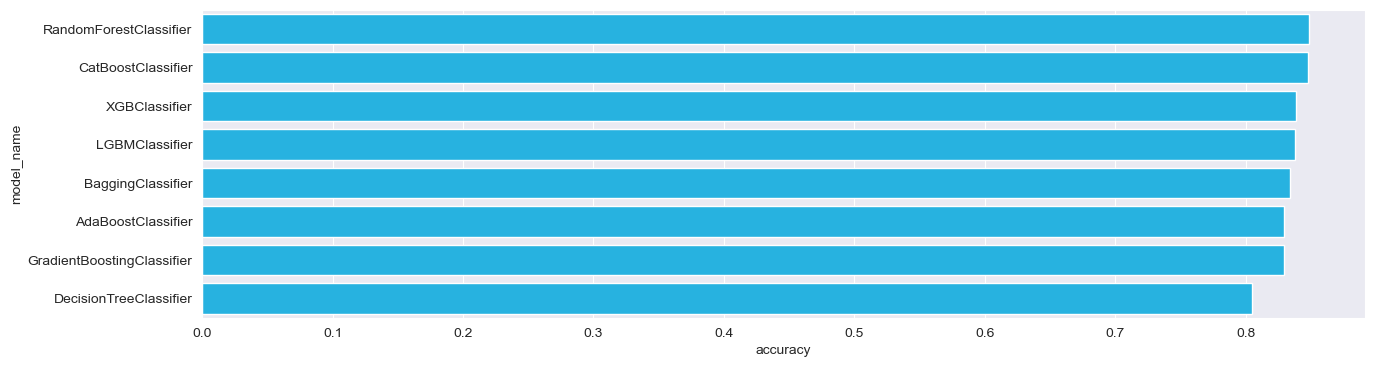

In [13]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "accuracy"]].sort_values(by="accuracy", ascending=False), 
y="model_name",x="accuracy", 
orient="h", 
color="#08C2FF"
)

<Axes: xlabel='precision', ylabel='model_name'>

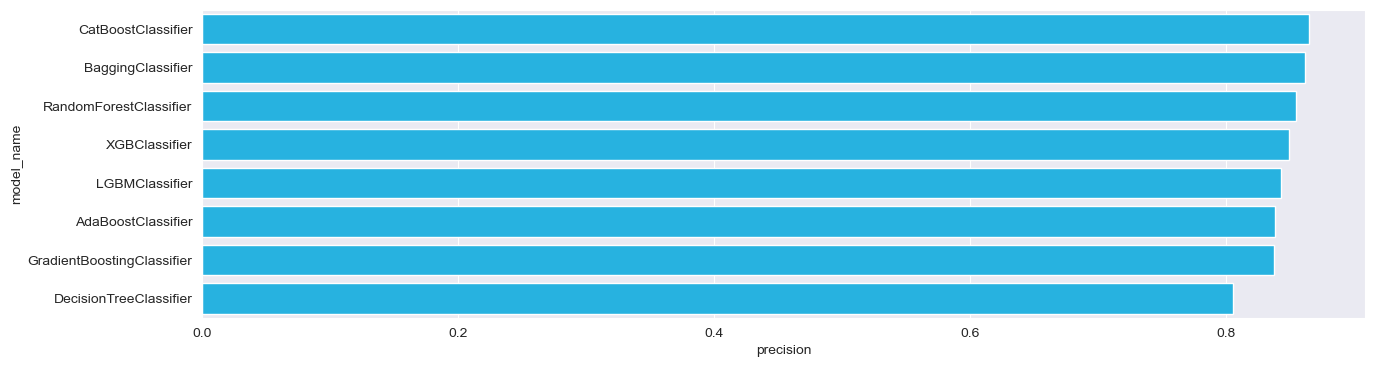

In [14]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "precision"]].sort_values(by="precision", ascending=False), 
y="model_name",x="precision", 
orient="h", 
color="#08C2FF"
)

<Axes: xlabel='recall', ylabel='model_name'>

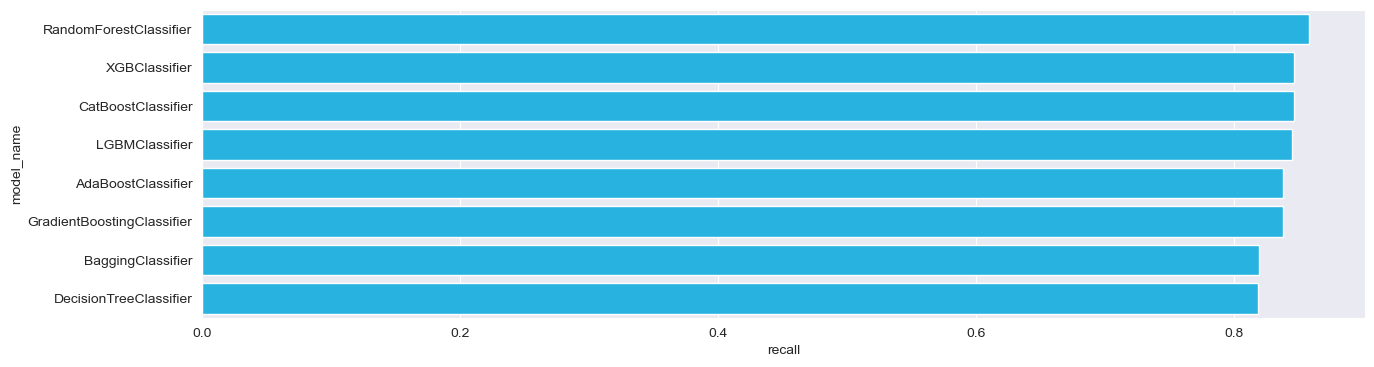

In [15]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "recall"]].sort_values(by="recall", ascending=False), 
y="model_name",x="recall", 
orient="h", 
color="#08C2FF"
)

<Axes: xlabel='f1', ylabel='model_name'>

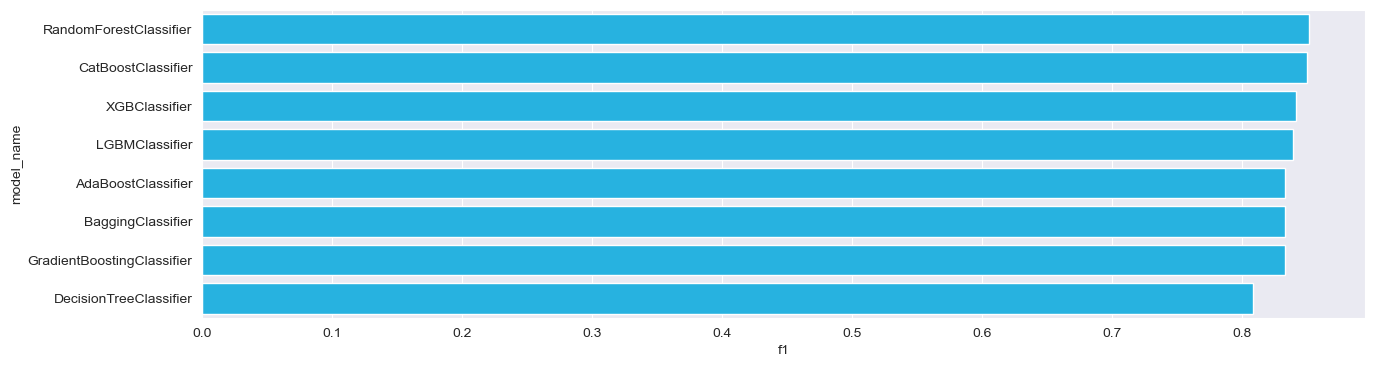

In [16]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "f1"]].sort_values(by="f1", ascending=False), 
y="model_name",x="f1", 
orient="h", 
color="#08C2FF"
)

<Axes: xlabel='roc_auc', ylabel='model_name'>

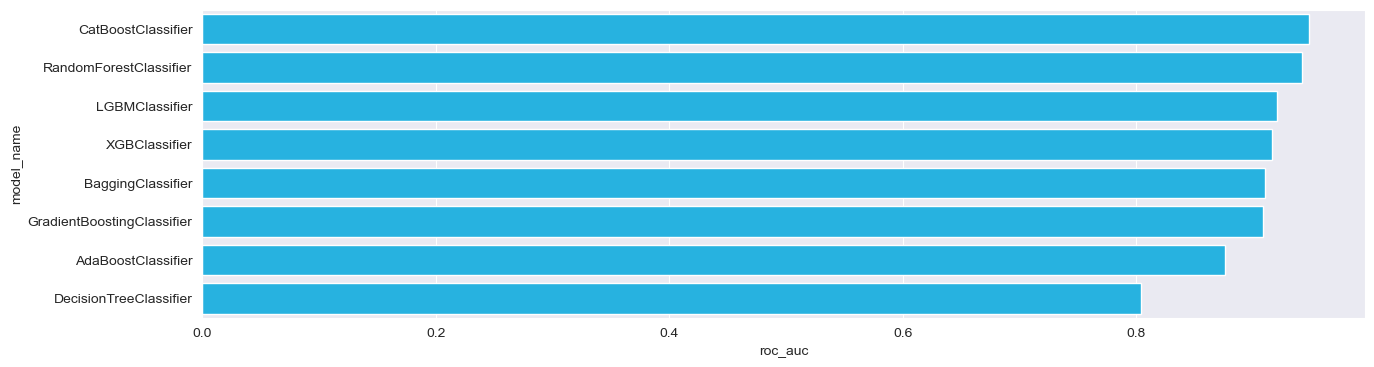

In [17]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "roc_auc"]].sort_values(by="roc_auc", ascending=False), 
y="model_name",x="roc_auc", 
orient="h", 
color="#08C2FF"
)

<Axes: xlabel='elapsed_time', ylabel='model_name'>

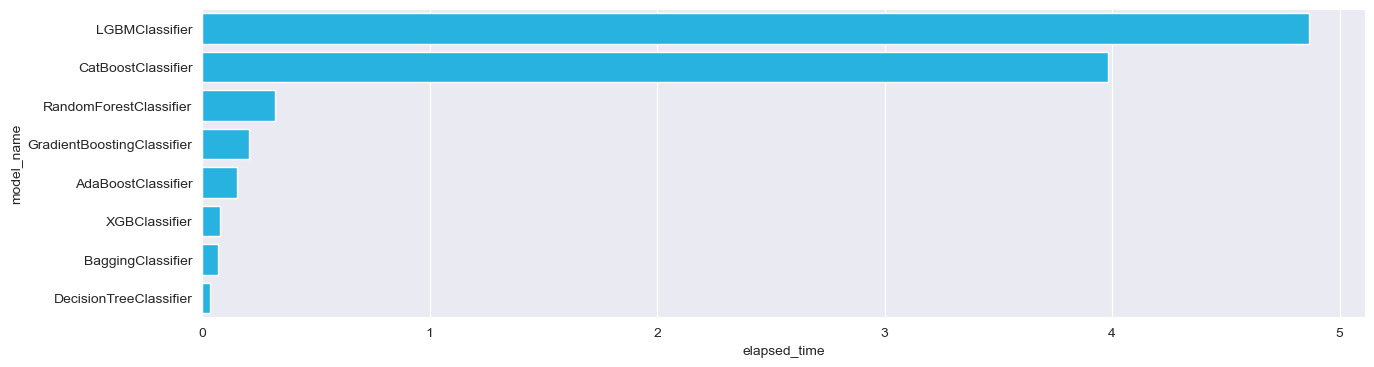

In [18]:
plt.figure(figsize=(15,4))
sns.barplot(data=trained_df[["model_name", "elapsed_time"]].sort_values(by="elapsed_time", ascending=False), 
y="model_name",x="elapsed_time", 
orient="h", 
color="#08C2FF"
)

[Text(0.5384615384615384, 0.9375, 'x[9] <= 0.75\ngini = 0.5\nsamples = 205\nvalue = [100, 105]'),
 Text(0.30128205128205127, 0.8125, 'x[11] <= 0.5\ngini = 0.325\nsamples = 98\nvalue = [20, 78]'),
 Text(0.4198717948717948, 0.875, 'True  '),
 Text(0.19230769230769232, 0.6875, 'x[3] <= 0.822\ngini = 0.161\nsamples = 68\nvalue = [6, 62]'),
 Text(0.1282051282051282, 0.5625, 'x[12] <= 2.5\ngini = 0.089\nsamples = 64\nvalue = [3, 61]'),
 Text(0.07692307692307693, 0.4375, 'x[3] <= -1.291\ngini = 0.037\nsamples = 53\nvalue = [1, 52]'),
 Text(0.05128205128205128, 0.3125, 'x[1] <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [1, 4]'),
 Text(0.02564102564102564, 0.1875, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.07692307692307693, 0.1875, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.10256410256410256, 0.3125, 'gini = 0.0\nsamples = 48\nvalue = [0, 48]'),
 Text(0.1794871794871795, 0.4375, 'x[4] <= -1.096\ngini = 0.298\nsamples = 11\nvalue = [2, 9]'),
 Text(0.15384615384615385, 0.3125, 'gi

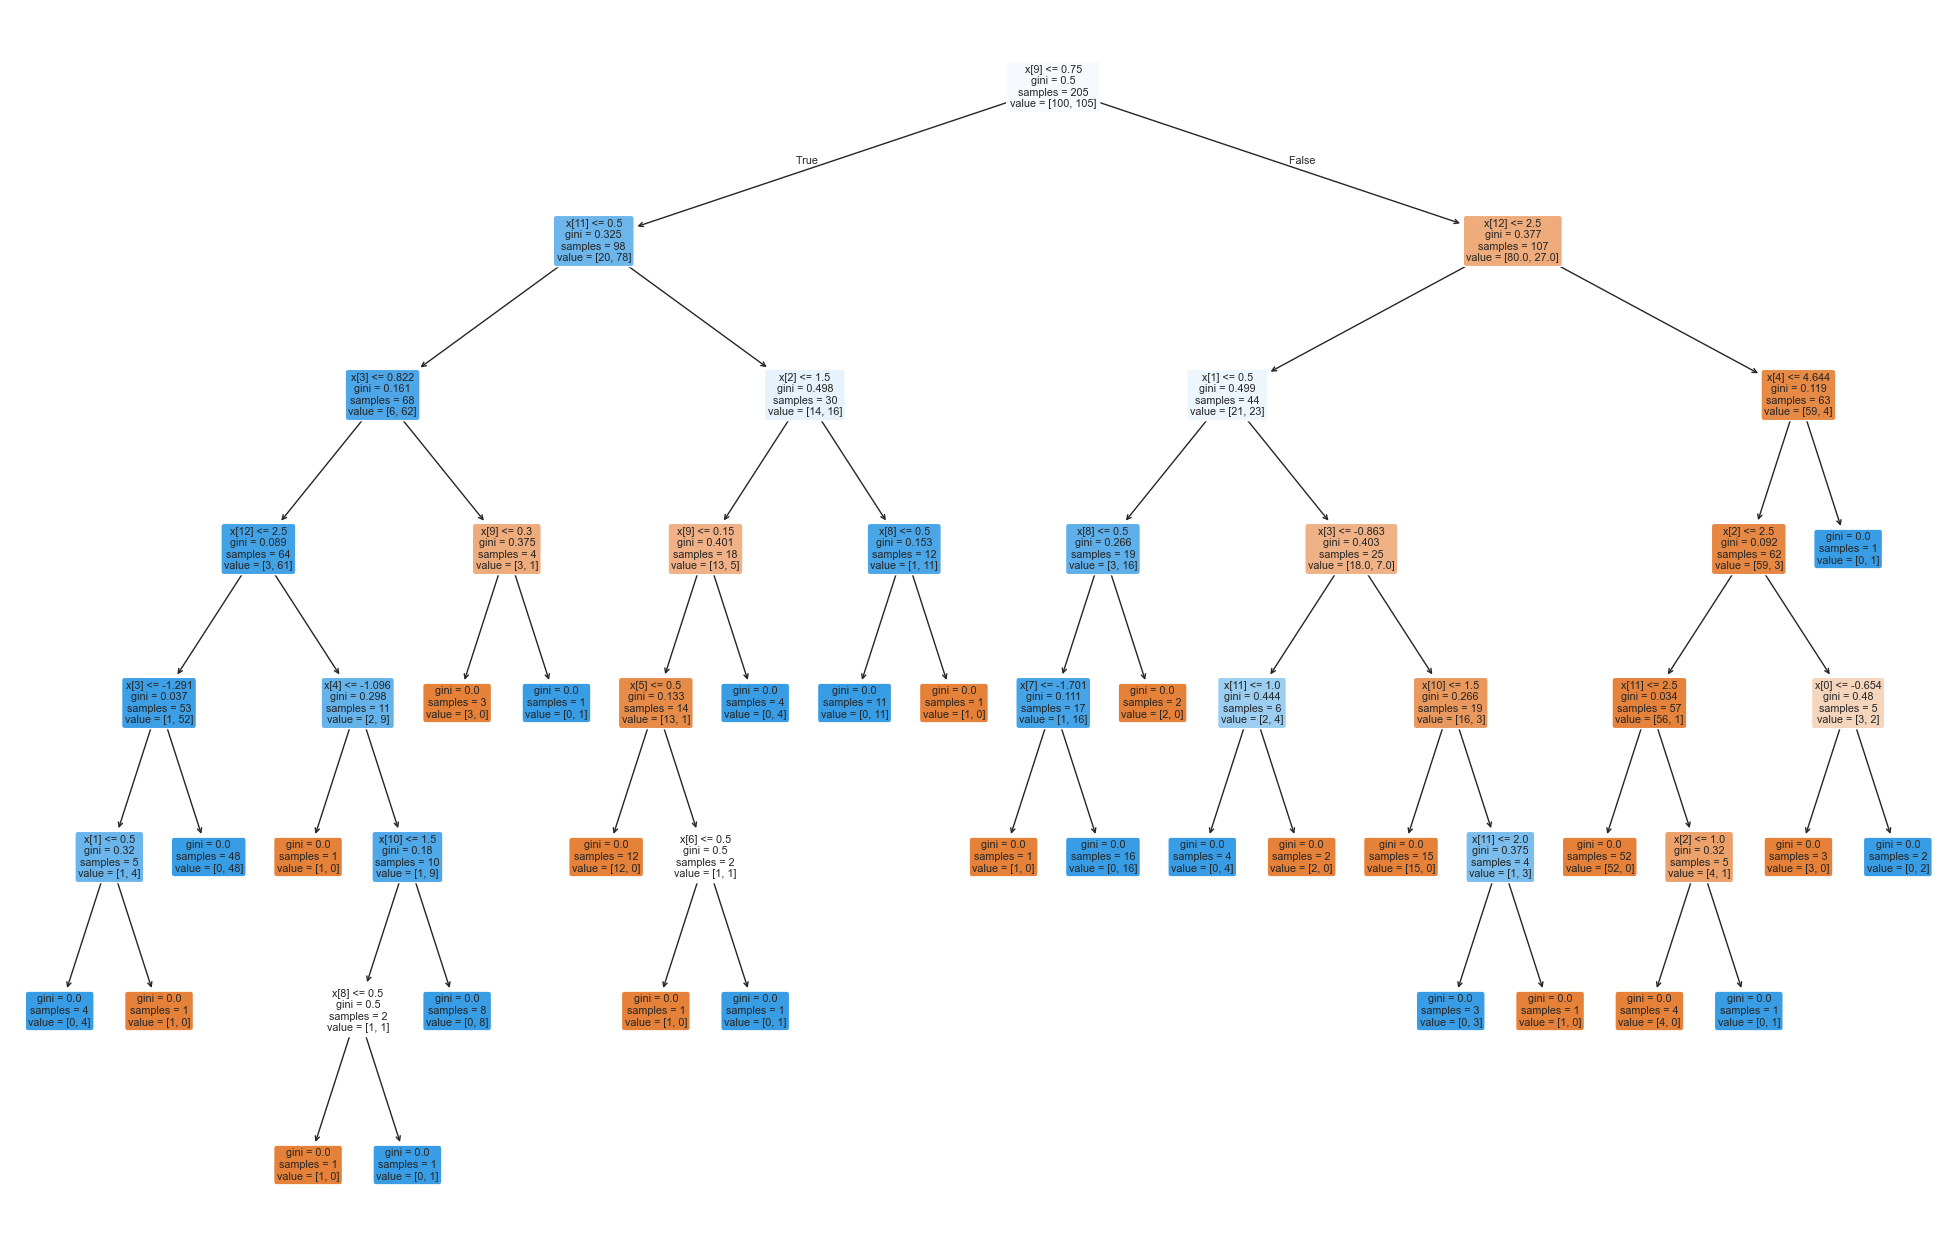

In [19]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

plt.figure(figsize=(25, 16))
plot_tree(decision_tree=tree, filled=True, rounded=True)

In [20]:
y_predict = tree.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))


                  precision    recall  f1-score   support

No Heart Disease       0.84      0.86      0.85       399
   Heart Disease       0.86      0.85      0.85       421

        accuracy                           0.85       820
       macro avg       0.85      0.85      0.85       820
    weighted avg       0.85      0.85      0.85       820



<Axes: >

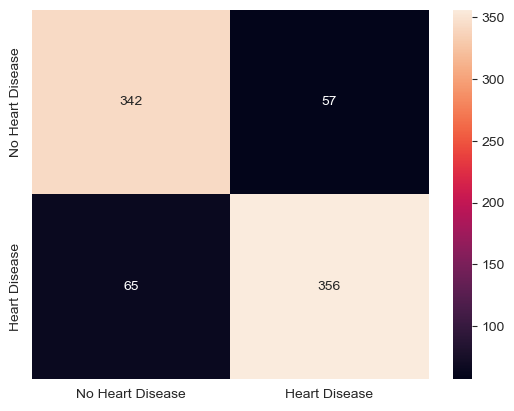

In [21]:
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [22]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]

voting_classifier = VotingClassifier(estimators=estimators, weights=[i + 1 for i in range(len(estimators))])
voting_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 105, number of negative: 100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512195 -> initscore=0.048790
[LightGBM] [Info] Start training from score 0.048790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('AdaBoostClassifier', AdaBoostClassifier()),
                             ('BaggingClassifier', BaggingClassifier()),
                             ('GradientBoostingClassifier',
                              GradientBoostingClassifier()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=N...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('LGBMClassifier', LGBMClassifier()),
                             ('CatBoostClassifier',
                              <catboost.core.CatBoostClassifier object at 0x000001E6C26542F0>)],
                 weights=[1, 2, 3, 4, 5, 6, 7, 8])

                  precision    recall  f1-score   support

No Heart Disease       0.90      0.86      0.88       399
   Heart Disease       0.87      0.91      0.89       421

        accuracy                           0.88       820
       macro avg       0.88      0.88      0.88       820
    weighted avg       0.88      0.88      0.88       820



<Axes: >

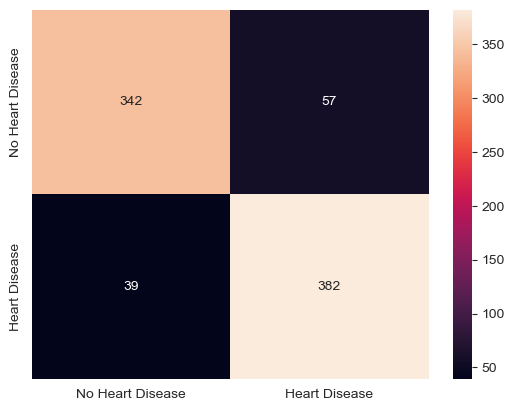

In [23]:
y_predict = voting_classifier.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [24]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]
stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=voting_classifier)
stacking.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 105, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512195 -> initscore=0.048790
[LightGBM] [Info] Start training from score 0.048790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks...
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=None,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)),
                                                                ('LGBMClassifier',
                                                                 LGBMClassifier()),
                                                                ('CatBoostClassifier',
                                                                 <catboost.core.CatBoostClassifier object at 0x000001E6C26542F0>)],
                                                    weights=[1, 2, 3, 4, 5, 6,
                                                             7, 8]),
                   n_jobs=-1, stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.86      0.87       399
   Heart Disease       0.87      0.89      0.88       421

        accuracy                           0.87       820
       macro avg       0.87      0.87      0.87       820
    weighted avg       0.87      0.87      0.87       820



<Axes: >

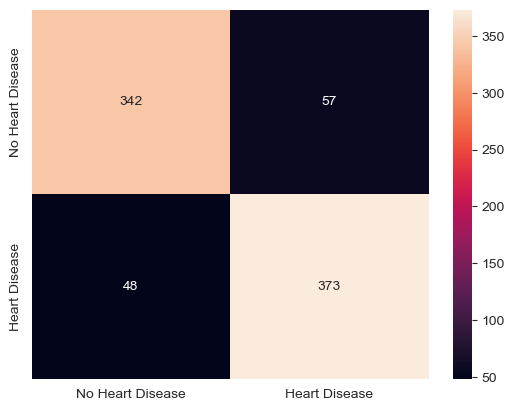

In [25]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [26]:
estimators = [
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]
stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=RandomForestClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              c...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6C200F950>)],
                   final_estimator=RandomForestClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.87      0.87      0.87       399
   Heart Disease       0.88      0.88      0.88       421

        accuracy                           0.88       820
       macro avg       0.88      0.88      0.88       820
    weighted avg       0.88      0.88      0.88       820



<Axes: >

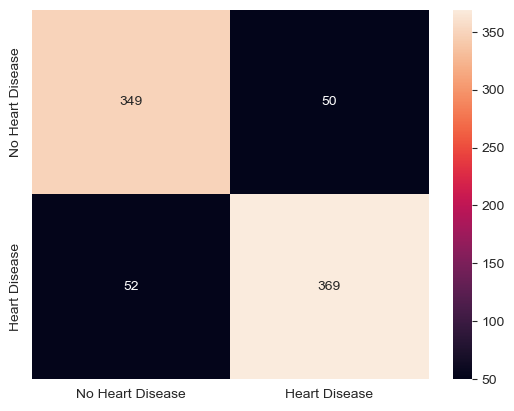

In [27]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [28]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]

stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=AdaBoostClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynod...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6AFB62180>)],
                   final_estimator=AdaBoostClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.92      0.86      0.89       399
   Heart Disease       0.88      0.93      0.90       421

        accuracy                           0.90       820
       macro avg       0.90      0.90      0.90       820
    weighted avg       0.90      0.90      0.90       820



<Axes: >

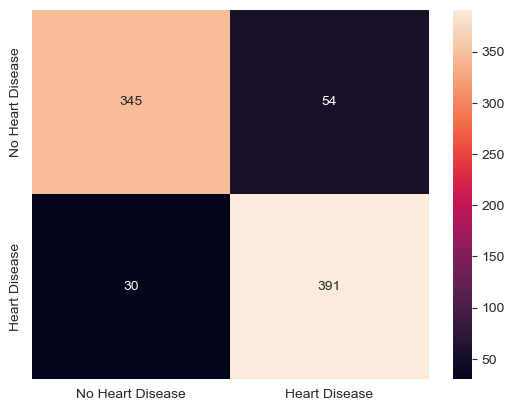

In [29]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [30]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]

stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=BaggingClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_byn...
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6AFF06090>)],
                   final_estimator=BaggingClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.87      0.87      0.87       399
   Heart Disease       0.88      0.87      0.88       421

        accuracy                           0.87       820
       macro avg       0.87      0.87      0.87       820
    weighted avg       0.87      0.87      0.87       820



<Axes: >

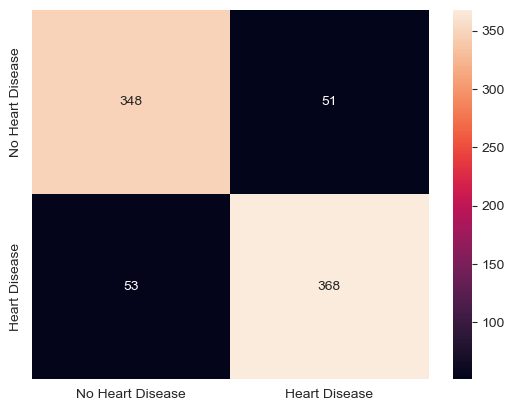

In [31]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [32]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]

stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=GradientBoostingClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6C277A900>)],
                   final_estimator=GradientBoostingClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.89      0.86      0.87       399
   Heart Disease       0.87      0.90      0.88       421

        accuracy                           0.88       820
       macro avg       0.88      0.88      0.88       820
    weighted avg       0.88      0.88      0.88       820



<Axes: >

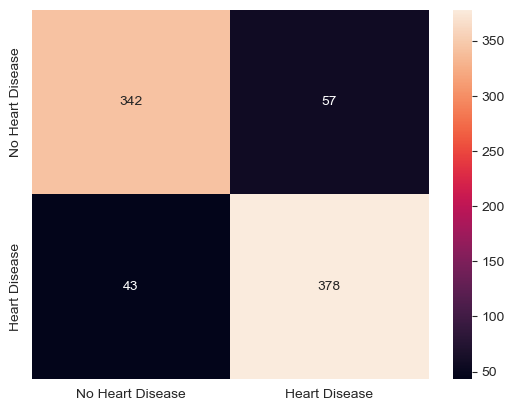

In [33]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [34]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]

stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=DecisionTreeClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6B0951AC0>)],
                   final_estimator=DecisionTreeClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.84      0.87      0.86       399
   Heart Disease       0.88      0.85      0.86       421

        accuracy                           0.86       820
       macro avg       0.86      0.86      0.86       820
    weighted avg       0.86      0.86      0.86       820



<Axes: >

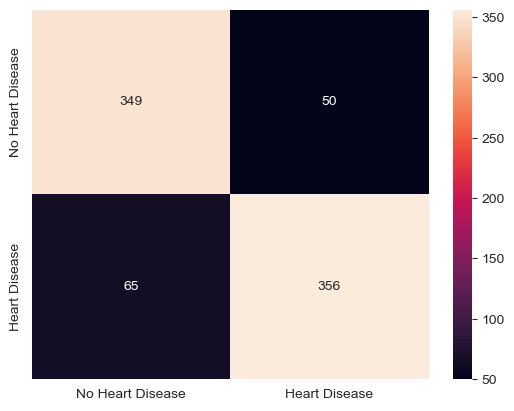

In [35]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [36]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
]
stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=CatBoostClassifier(silent=True))
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('LGBMClassifier', LGBMClassifier())],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x000001E6C363D2B0>,
                   n_jobs=-1, stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.88      0.88       399
   Heart Disease       0.89      0.89      0.89       421

        accuracy                           0.89       820
       macro avg       0.89      0.89      0.89       820
    weighted avg       0.89      0.89      0.89       820



<Axes: >

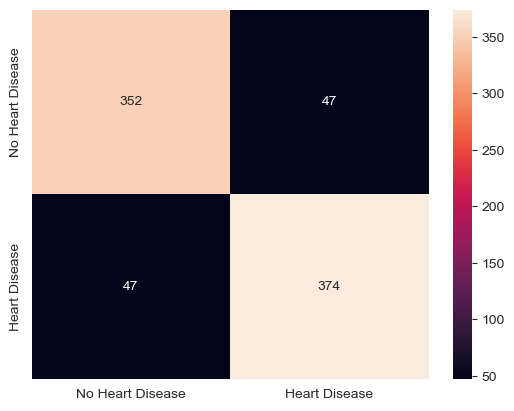

In [37]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [38]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("XGBClassifier", XGBClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]
stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=LGBMClassifier())
stacking.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 105, number of negative: 100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 205, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512195 -> initscore=0.048790
[LightGBM] [Info] Start training from score 0.048790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('CatBoostClassifier',
                                <catboost.core.CatBoostClassifier object at 0x000001E6B0B30E60>)],
                   final_estimator=LGBMClassifier(), n_jobs=-1,
                   stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.91      0.87      0.89       399
   Heart Disease       0.88      0.91      0.90       421

        accuracy                           0.89       820
       macro avg       0.89      0.89      0.89       820
    weighted avg       0.89      0.89      0.89       820



<Axes: >

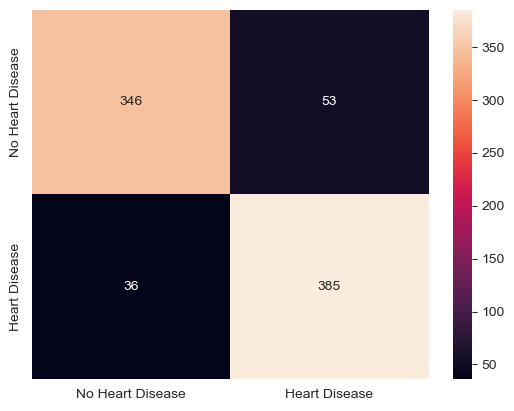

In [39]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])

In [40]:
estimators = [
    ("RandomForestClassifier", RandomForestClassifier()),
    ("AdaBoostClassifier", AdaBoostClassifier()),
    ("BaggingClassifier", BaggingClassifier()),
    ("GradientBoostingClassifier", GradientBoostingClassifier()),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("LGBMClassifier", LGBMClassifier()),
    ("CatBoostClassifier", CatBoostClassifier(silent=True)),  # Setting silent=True to suppress warnings
]
stacking = StackingClassifier(estimators=estimators, stack_method="predict", n_jobs=-1, final_estimator=XGBClassifier())
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('RandomForestClassifier',
                                RandomForestClassifier()),
                               ('AdaBoostClassifier', AdaBoostClassifier()),
                               ('BaggingClassifier', BaggingClassifier()),
                               ('GradientBoostingClassifier',
                                GradientBoostingClassifier()),
                               ('DecisionTreeClassifier',
                                DecisionTreeClassifier()),
                               ('LGBMClassifier', LGBMClassifier()),
                               ('CatBoostClassifier',
                                <catboost.c...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=-1, stack_method='predict')

                  precision    recall  f1-score   support

No Heart Disease       0.93      0.86      0.89       399
   Heart Disease       0.87      0.94      0.90       421

        accuracy                           0.90       820
       macro avg       0.90      0.90      0.90       820
    weighted avg       0.90      0.90      0.90       820



<Axes: >

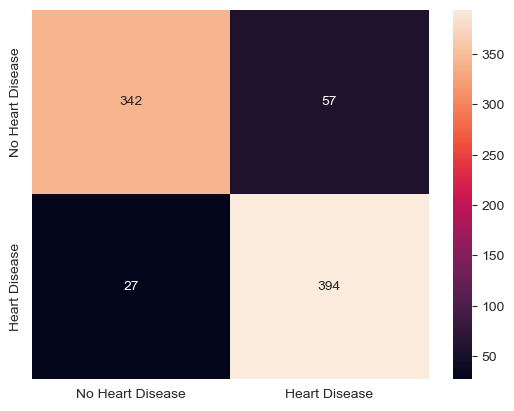

In [41]:
y_predict = stacking.predict(X_test)

print(classification_report(y_true=y_test, y_pred=y_predict, target_names=['No Heart Disease', 'Heart Disease']))
cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, fmt="d", xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])